Import required modules

In [1]:
from datetime import datetime
import helper as hp
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Set Required Base Path (*Note*: relative paths or $Home (~) directory not working)

In [12]:
hp.FIRED_BASE_FOLDER = "/Users/voelkerb/dump/FIRED/"

startDay = "2020.07.13" # None to select dataset first day
stopDay = "2020.07.16" # None to select dataset last day (timepoint) 
# will select min(stopDay, lastDayOfDataset) and max(startDay, firstDayOfDataset)
start, end = hp.getRecordingRange(startDay, stopDay)
print("Time of Interest: " + hp.time_format_ymdhms(start) + " -> " + hp.time_format_ymdhms(end))

Time of Interest: 2020.07.12 00:00:00.000 -> 2020.07.15 23:59:59.960


Load annotation for the appartment's lighting

In [3]:
includeLights = [] # if empty, all are used

# Load annotation
lights = hp.loadAnnotations(hp.LIGHT_ANNOTATION)
if len(includeLights) > 0:
    lights = [light for light in lights if light["name"] in includeLights]
# convert data to time range and remove data out of time
for light in lights:
    light["data"] = hp.convertToTimeRange(light["data"])
    light["data"] = [entry for entry in light["data"] if entry["startTs"] < end and entry["stopTs"] > start]

for light in lights: 
    if "name" in light: print(light["name"])

bathroom ceiling light
mirror light
bedroom ceiling light #1
bedroom ceiling light #2
bedroom ceiling light #3
bedside lamp left
bedside lamp right
cubby ceiling light
hallway ceiling light #1
hallway ceiling light #2
hallway ceiling light #3
kitchen spot light
dining light
livingroom ceiling light #1
livingroom ceiling light #2
livingroom ceiling light #3
spot light #1
stand light
spot light #2
spot light #3
workroom ceiling light #1
workroom ceiling light #2
workroom ceiling light #3


Text(0.5, 0, 'Time of day')

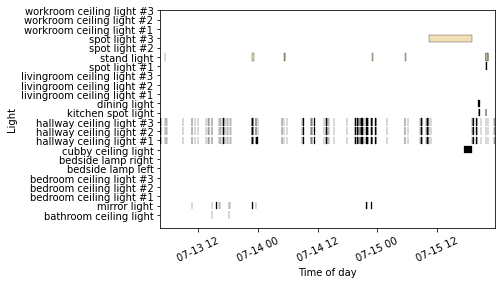

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)

for index, light in enumerate(lights):
    for entry in light["data"]:
        if entry["state"].lower() != "on": continue

        startTs = max(start, entry["startTs"])
        stopTs = min(end, entry["stopTs"])
       
        color = 'k'
        # extract color from hexadecimal string
        if ("color" in entry and entry["color"] is not None 
            and isinstance(entry["color"], str) and entry["color"].lower() != 'none'):
            color = tuple(float(int(entry["color"][i:i+2], 16))/255.0 for i in (0, 2, 4))
        # extract dimm setting
        if "dim" in entry:
            dim = float(entry["dim"])/100.0
            color = tuple(min(0.9, float(c)*1.0/dim + 0.1) for c in color)
        # plot
        startDate = mdates.date2num(datetime.fromtimestamp(startTs))
        endDate = mdates.date2num(datetime.fromtimestamp(stopTs))
        ax.barh(index, endDate-startDate, align='center', left=startDate, color=color, linewidth=0.3, edgecolor='k')

# prettify plot
plt.yticks([i for i in range(len(lights))], [light["name"] for light in lights])
plt.xticks( rotation=25 )
ax.xaxis_date()
ax.set_ylabel("Light")
ax.set_xlabel("Time of day")

Load artificial light power reconstructed from the annotation data

In [5]:
lightsData = hp.getPowerForLights(1, start, end)
if len(includeLights) > 0:
    lights = [light for light in lights if light["name"] in includeLights]

Text(0.5, 0, 'Time of day')

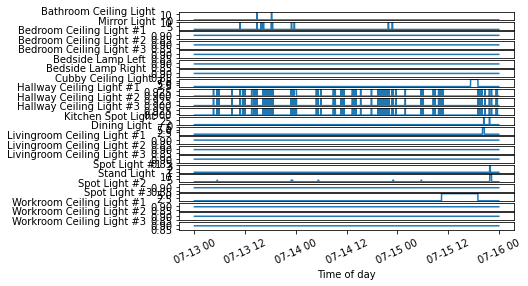

In [6]:
timestamps = np.linspace(start, end, int(end) - int(start))
dates = [datetime.fromtimestamp(ts) for ts in timestamps]

fig, axes = plt.subplots(len(lightsData),1, sharex=True)
# special case for only on light/plot
try: axes[0]
except (TypeError, IndexError) as e: axes = [axes]
for i, light in enumerate(lightsData):
    axes[i].plot(dates, light["data"]["s"])
    axes[i].set_ylabel(hp.prettyfyApplianceName(light["name"]),rotation=0, ha='right')
    if i != len(lightsData)-1:
        axes[i].get_xaxis().set_visible(False)
        axes[i].get_xaxis().set_ticks([])

plt.xticks( rotation=25 )

axes[-1].xaxis_date()

axes[-1].set_xlabel("Time of day")

Thats it for lights folks, lets continue with temperture and humidity.
We used DHT22 connected to ESP32 which sends temperature readings on change over MQTT.

**NOTE:** Bedroom sensor is DHT21 -> you can see how bad this sensor actually is compared to the DHT22

In [7]:
rooms = [] # select specific rooms or leave empty 

sensorData = hp.loadAnnotations(hp.SENSOR_ANNOTATION, loadData=True)
# remove sensor data out of time range
for sensor in sensorData:
    sensor["data"] = [entry for entry in sensor["data"] if entry["timestamp"] < end and entry["timestamp"] > start]

# only the data in the selected rooms
if len(rooms) == 0: rooms = list(set([sensor["room"] for sensor in sensorData]))
else: sensorData = [s for s in sensorData if s["room"] in rooms]

print(rooms)
 

['workroom', 'bedroom', 'livingroom']


Text(0.5, 0, 'Time of day')

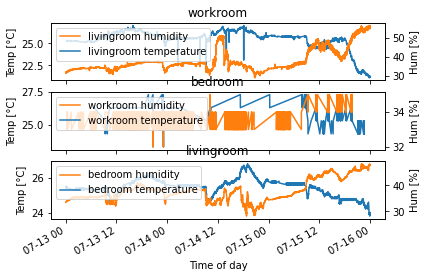

In [8]:
fig, axes = plt.subplots(len(rooms), 1, sharex=True)

# special case only one room
try: axes[0]
except (TypeError, IndexError) as e: axes = [axes]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# store lines for proper legend on dual axisi plots
lines = [[] for r in rooms]
# store second axis for humidity readings
axes2 = []
for sensor in sensorData:
    timestamps = [s["timestamp"] for s in sensor["data"]]
    dates = [datetime.fromtimestamp(ts) for ts in timestamps]
    ax = axes[rooms.index(sensor["room"])]
    ax.set_title(sensor["room"])
    if "humidity" in sensor["name"]:
        ax = ax.twinx()
        ci = 1
        ax.set_ylabel("Hum [%]")
        axes2.append(ax)
    else:
        ci = 0
        ax.set_ylabel("Temp [°C]")
    l = ax.plot(dates, [s["value"] for s in sensor["data"]], label=sensor["name"], color=colors[ci])
    lines[rooms.index(sensor["room"])].extend(l)
# add legend
for i, ax in enumerate(axes2):
    ax.legend(lines[i], [l.get_label() for l in lines[i]], loc="upper left")
ax.xaxis_date()
plt.xticks( rotation=25 )
fig.autofmt_xdate()
axes[-1].set_xlabel("Time of day")

Now lets move on to device annotation data.

In [9]:
devices = [] # select specific devices or leave empty 

deviceList = hp.loadAnnotations(hp.DEVICE_ANNOTATION, loadData=True)

    
if len(devices) == 0: devices = [d["name"] for d in deviceList]
else: deviceList = [d for d in deviceList if d["name"] in devices]


# Remove data out of time range
for dev in deviceList:
    dev["data"] = [entry for entry in dev["data"] if entry["timestamp"] < end]
    dev["data"] = [entry for entry in dev["data"] if entry["timestamp"] > start]

print(devices)

['espresso machine', 'hifi system', 'television']


In [10]:
# Remove duplicates
for dev in deviceList:
    oldState = "_"
    dnew = []
    st = start - 60.0
    for entry in dev["data"]:
        # if next state is not the same
        if entry["state"] != oldState: dnew.append(entry)
        # or if more than 60s have passed since the last state and we can't convert it to a number
        elif entry["timestamp"]-st > 60 and not isinstance(entry["state"], int): dnew.append(entry)
        oldState = entry["state"]
        st = entry["timestamp"]
    dev["data"] = dnew

Text(0.5, 0, 'Time of day')

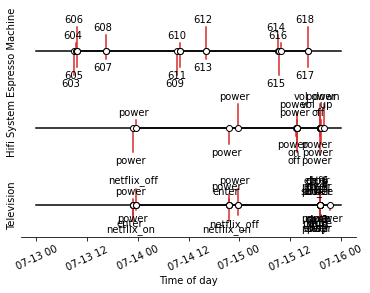

In [11]:
fig, axes = plt.subplots(len(deviceList), 1, sharex=True)

# special case only one device
try: axes[0]
except (TypeError, IndexError) as e: axes = [axes]

for i, dev in enumerate(deviceList):
    ax = axes[i]
    # Plot base line
    ax.plot([datetime.fromtimestamp(start), datetime.fromtimestamp(end)], [0,0], c='k')
    timestamps = [s["timestamp"] for s in dev["data"]]
    dates = [datetime.fromtimestamp(ts) for ts in timestamps]
    names = [s["state"] for s in dev["data"]]
    # Levels to display text at
    levels = np.tile([-0.75, 0.25, -0.5, 0.75, -0.25, 0.5], int(np.ceil(len(dates)/6)))[:len(dates)]
    # Add marker lines and dots
    markerline, stemline, baseline = ax.stem(dates, levels, linefmt="C3-", basefmt="k-")
    # plot marker
    plt.setp(markerline, mec="k", mfc="w", zorder=3)
    # Shift the markers to the baseline by replacing the y-data by zeros.
    markerline.set_ydata(np.zeros(len(dates)))

    # annotate lines
    vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
    for d, l, r, va in zip(dates, levels, names, vert):
        ax.annotate(r, xy=(d, l), xytext=(-3, np.sign(l)*3), textcoords="offset points", va=va, ha="center")


    for spine in ["left", "top", "right", "bottom"]:
        ax.spines[spine].set_visible(False)
    
    label = hp.prettyfyApplianceName(dev["name"])
    ax.set_ylabel(label)

    ax.set_yticks([])
    ax.yaxis.set_ticklabels([])
    if i != len(deviceList) - 1:
        ax.xaxis.set_visible(False)
        ticks = ax.get_xticks()
        ax.set_xticks([])
        ax.xaxis.set_ticklabels([])
        ax.set_ylim([-1,1])
    else:
        ax.spines["bottom"].set_visible(True)
        ax.set_ylim([-1.5,1.5])
    # ax.margins(y=0.1)

    # Rotate x labels
plt.xticks(rotation=25)
axes[-1].set_xlabel("Time of day")